<p align="center">
<img src='https://github.com/manuelmorgado/AQiPT/blob/main/resources/aqipt_logo.png?raw=true' width="400" />
</p>


\textbf{Author}: Manuel A. Morgado V. (morgadovargas@unistra.fr)

\textbf{Affiliation}: 

- \textit{Institut de Science et d’Ingénierie Supramoléculaires (ISIS, UMR7006), University of Strasbourg and CNRS}

- \textit{Centre Européen de Sciences Quantiques (CESQ-ISIS, UMR7006), University of Strasbourg and CNRS}

\textbf{Created}: Jun.10, 2021

\textbf{Last Modification}: Jun.16, 2021

\textbf{License}: http://www.apache.org/licenses/LICENSE-2.0

<div class="alert alert-block alert-danger">

**Module** : transpiler
    
**Class** : algGate


</div>

<div class="alert alert-block alert-danger">

**TO DO**

- Generalized multi-qubit gates
- Matrix pCZ()
- Equivalency of the native gates to cannonical ones using Qiskit

</div>

In [1]:
#libs
from numpy import asarray, cos, sin, exp, sqrt, pi
import qutip as qt

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import cm
import imageio

from IPython.display import clear_output
from IPython.core.display import HTML
# with open( './custom.css', 'r' ) as f: style = f.read()
# HTML( style )
from IPython.display import clear_output
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:85% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [3]:
#visualization functions
def plotBloch(state_lst, figure=None, subfigure=None, pltshow=True):
    
    if figure or subfigure is None:
        b= qt.Bloch()
    else:
        b= qt.Bloch(fig=figure, axis=subfigure)

    for states in state_lst:
        b.add_states(states,'point')
    
    if pltshow==True:
        b.render()
        return b
    else:
        return b

def mp4Gate(state_lst, marker='o', psize=10, pcolor='dodgerblue'):
    
    fig = plt.figure()
    ax = Axes3D(fig, azim=-40, elev=30)
    sphere = qt.Bloch(axes=ax)

    def animate(i):
        sphere.clear()

        for j in range(i):
            sphere.add_states(state_lst[j],'point')
        sphere.add_states(state_lst[i])

        sphere.point_marker = marker
        sphere.point_size = [psize]
        sphere.point_color = [pcolor]

        sphere.make_sphere()
        return ax

    def init():
        sphere.vector_color = ['r']
        return ax

    ani = animation.FuncAnimation(fig, animate, np.arange(len(state_lst)),
                                  init_func=init, blit=False, repeat=True)
    ani.save('bloch_sphere.mp4', fps=20)

def gif4Bloch(states, duration=0.1, save_all=False,  fig=None, axes=None):
    b = qt.Bloch(fig, axes)
    b.vector_color = ['r']
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]

    for i in range(length):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)],'point')

        if save_all:
            b.save(dirc='tmp') #saving images to tmp directory
            filename="tmp/bloch_%01d.png" % i
        else:
            filename='temp_file.png'
            b.save(filename)
        images.append(imageio.imread(filename))
    imageio.mimsave('bloch_anim.gif', images, duration=duration)
        
def gif4QST(op_list, op_basis, op_label, gate_name,  duration=0.1, save_all=False, gifname='qst_anim.gif'):       
    
    plt.figure()
    images=[]
    for i in range(len(op_list)):
        
        U_psi = op_list[i]
        U_rho = qt.spre(U_psi) * qt.spost(U_psi.dag()) #creates the superoperator

        chi = qt.qpt(U_rho, op_basis); #calculates the Xi matrix for the tomography

        qt.tomography.qpt_plot_combined(chi, op_label, gate_name); #quantum state tomography
        
        
        if save_all:
            filename="tmp/qst_%01d.png" % i;
            plt.savefig(filename);
        else:
            filename='temp_file.png';
            plt.savefig(filename);
        images.append(imageio.imread(filename));
        plt.close()
    imageio.mimsave(gifname, images, 'GIF', duration=duration);

# Algebraic native Rydberg quantum gates

Based in the latest summary of Rydberg gates on this review article, there is a distinction of different types of native Rydberg quantum gates. Not only considering the nature of the gates over the number of qubits, but also in the nature of the simultaneity of the gates, they can be broadly divide in 3 classes:

    -Single qubit gates
    -Two qubits gates
    -Multi-qubits gates or parallel-controlled qubit gates

In the following cells is presented a series of functions that summarize these native gate set for Rydberg qubits.

<div class="alert alert-block alert-warning">

**Info**

These "algebraic" gates are based on a specific sequence of physical operations that might no be optimal, so if you would like to go a bit deeper on this it would be necessary to dig on the Hamiltonian (theoretical) sequence or at the level of lab control pulses (experimental).

</div>

In [4]:
#native algebraic Rydberg gates
#single qubit gates
'''
Here we find the single qubits gates for Rydberg qubits.

    Uxy(phi, alpha)
        phi (float) : angle
        alpha (float): angle
'''
# Uxy gate
def Uxy(phi, alpha):
    m11 = cos(phi/2); 
    m12 = -1j*sin(phi/2)*exp(1j*alpha);
    
    m21 = -1j*sin(phi/2)*exp(-1j*alpha); 
    m22 = cos(phi/2);
    return qt.Qobj(asarray([[m11, m12],[m21, m22]]))

#two qubits gates
'''
Here we find the two qubits gates for Rydberg qubits.

    Controlled-Uxy
        CUxy(phi, alpha)
            phi (float) : angle
            alpha (float): angle

    Controlled-phase
        CPHASE(phi00, phi01, phi10, phi11)
            phi00 (float) : angle
            phi01 (float): angle
            phi10 (float): angle
            phi11 (float): angle

    Controlled-Pauli Z
        CZ()

    Rydberg dipole exchange
        XY(phi)
            phi (float): angle
'''
# CUxy gate
def CUxy(phi, alpha):
    m11 = cos(phi/2); 
    m12 = -1j*sin(phi/2)*exp(1j*alpha); 
    m13 = 0; 
    m14 = 0;
    
    m21 = -1j*sin(phi/2)*exp(-1j*alpha); 
    m22 = cos(phi/2); 
    m23 = 0; 
    m24 = 0;
    
    m31 = 0; 
    m32 = 0; 
    m33 = 1; 
    m34 = 0;
    
    m41 = 0; 
    m42 = 0; 
    m43 = 0; 
    m44 = 1;
    return qt.Qobj(asarray([[m11, m12, m13, m14],[m21, m22, m23, m24], [m31, m32, m33, m34],[m41, m42, m43, m44]]))

# CPHASE gate
def CPHASE(phi00, phi01, phi10, phi11):
    m11 = exp(1j*phi00); 
    m12 = 0; 
    m13 = 0; 
    m14 = 0;

    m21 = 0; 
    m22 = exp(1j*phi01); 
    m23 = 0; 
    m24 = 0;

    m31 = 0; 
    m32 = 0; 
    m33 = exp(1j*phi10); 
    m34 = 0;

    m41 = 0; 
    m42 = 0; 
    m43 = 0; 
    m44 = exp(1j*phi11);
    return qt.Qobj(asarray([[m11, m12, m13, m14],[m21, m22, m23, m24], [m31, m32, m33, m34],[m41, m42, m43, m44]]), dims = [[2,2],[2,2]])

#CZ gate
def CZ():
    return CPHASE(0, 0, 0, pi)    

# XY gate
def XY(phi):
    m11 = 1; 
    m12 = 0; 
    m13 = 0; 
    m14 = 0;

    m21 = 0; 
    m22 = cos(phi); 
    m23 = -1j*sin(phi); 
    m24 = 0;

    m31 = 0; 
    m32 = -1j*sin(phi); 
    m33 = cos(phi); 
    m34 = 0;

    m41 = 0; 
    m42 = 0; 
    m43 = 0; 
    m44 = 1;
    return qt.Qobj(asarray([[m11, m12, m13, m14],[m21, m22, m23, m24], [m31, m32, m33, m34],[m41, m42, m43, m44]]))


#multi-qubits gates
'''
Here we find the single qubits gates for Rydberg qubits.

    Parallel-controlled-Uxy
        pCUxy(theta, varphi)
            theta (float) : angle
            varphi (float): angle

    Parallel-controlled-Pauli Z
        pCZ(phi)
            phi (float): angle
'''
#pCUxy gate
def pCUxy(theta, varphi):
    m11 = cos(theta/2); 
    m12 = -1j*sin(theta/2)*exp(1j*varphi)/sqrt(2); 
    m13 = -1j*sin(theta/2)*exp(1j*varphi)/sqrt(2); 
    m14 = 0;
    
    m21 = 1j*sin(theta/2)*exp(-1j*varphi)/sqrt(2);
    m22 = cos(theta/4)**2; 
    m23 = -sin(theta/4)**2;
    m24 = 0;
    
    m31 = 1j*sin(theta/2)*exp(-1j*varphi)/sqrt(2);
    m32 = m23;
    m33 = cos(theta/4)**2; 
    m34 = 0;
    
    m41 = 0; 
    m42 = 0; 
    m43 = 0; 
    m44 = 1;
    return qt.Qobj(asarray([[m11, m12, m13, m14],[m21, m22, m23, m24], [m31, m32, m33, m34],[m41, m42, m43, m44]]), dims = [[2,2],[2,2]])

#pCZ gate
def pCZ(phi):
    return CPHASE(0, phi, phi, 2*phi-pi)

# Globalphase gate
def globphase(arg_value):
    return qt.globalphase(arg_value['theta'])


---

<div class="alert alert-block alert-success">

**Let's start it!**

We now will do some show-up of these fun gates!

</div>

## Single qubit gates

This typer of gates are the most intuitive in the graphical way, since it just consider all possible states from rotations in the Bloch sphere that maps the complex-valued state of a two-level quantum system into a Euclidean 3-dimensional sphere.

### U$_{xy}(\phi, \alpha)$
The most simple one is the U$_{xy}(\phi, \alpha)$ gate, this allows rotations along the Bloch sphere in terms of two angles. This would represent our single qubit gate set, considering different values of the angles $\phi, \alpha$. In the cell bellow you will find out that we applied a sequence of this gates considering different values of the angles that takes the state in $|0\rangle$ and transform first ot the equator, then rotate around the vertical access to come back to the original state.


<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
\text{U}_{xy}(\theta, \varphi) = \begin{pmatrix} 
cos(\theta/2) &  -i sin(\theta/2)e^{i\varphi} \\
-i sin(\theta/2)e^{-i\varphi} & cos(\theta/2) 
\end{pmatrix}
\end{equation}

</div>

In [271]:
phi_vals = np.concatenate((np.linspace(0,-pi/2, 20), [-pi/2]*20, np.linspace(-pi/2, 0, 20))); #sequence of values of the angle phi
alpha_vals = np.concatenate((np.zeros(20), np.linspace(0,pi/2, 20), [pi/2]*20)); #sequence of values of the angle alpha

state_lst = [];
for phi, alpha in zip(phi_vals, alpha_vals):
    state_lst.append(Uxy(phi, alpha)*qt.basis(2,0)); #adding the states along the trajectory

In [272]:
gif4Bloch(state_lst, duration=0.1, save_all=False); #generating the gif plot movie

![SegmentLocal](bloch_anim.gif "segment")

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following quantum circuit element:

    
<img src="resources/UxyCircuit.png" width="300" dpi="500"/>

</div>

## Two-qubit gates

We are now going to begin an important element of quantum computing that are the gates implemented to more than one qubit at the time, this contribute to the generation of quantum algorithms that requires qubits gates operation that depends of the value of other (quantum) registers i.e., conditional gates. This concept of control comes from the gates in classical computation, such as: NAND gates. 

In the case of the native Rydberg quantum gates, there are several controlled gates that can even be generalized to multi-qubit gates, where the role of the control and controlled qubits are played by both qubits. Even the multi-qubit gates can be generalized even more by including other qubits in the parallelization of gates, for instance considering the blockade effect that can be consider by $n$ number of qubits in the blockade area; this will be shown in coming sections.


### CU$_{xy}(\phi, \alpha)$

This gate is take the single qubit gate U$_{xy}(\phi, \alpha)$ and apply its action i.e.,$|0\rangle \leftrightarrow |1\rangle$ depending of the value of the states of the control qubit that is unnafected to the action of this gate.

<div>
<img src="resources/CUxy.png" width="300" dpi="500"/>
</div>


<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
\text{CU}_{xy}(\theta, \varphi) = \begin{pmatrix} 
cos(\theta/2) &  -isin(\theta/2)e^{i\varphi} & 0 & 0\\
-isin(\theta/2)e^{i\varphi} & cos(\theta/2) & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation}

</div>

In [284]:
phi_vals = np.concatenate((np.linspace(0,-pi/2, 10), [-pi/2]*10, np.linspace(-pi/2, 0, 10))); #sequence of values of the angle phi
alpha_vals = np.concatenate((np.zeros(10), np.linspace(0,pi/2, 10), [pi/2]*10)); #sequence of values of the angle alpha

ops_lst = [];
for phi, alpha in zip(phi_vals, alpha_vals):
    ops_lst.append(CUxy(phi, alpha)); #adding the states along the trajectory

We now a face one of the complexities of quantum computing, that is the visualization of more or large number of qubit states. One solution is to use what it is call: Quantum State Tomography (QST) that is a a projection of the final state in a combination of basis operators in order to obtain the outcome probability together with the phase. However, there is other solutions to this problem, for example in Qiskit, one can be visualize it in a sort of 'generalized' Bloch sphere called ```qSphere```. Meanwhile we are going to use the command of QuTiP for doing QST.

In [313]:
gate_name = 'CU$_{xy}$'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name); #creates the quantum state tomography for the different operators and plot them in a .gif file


<Figure size 432x288 with 0 Axes>

![SegmentLocal](resources/qst_animCUxy.gif "segment")

<div class="alert alert-block alert-danger">

**Warning!**

Notice that the animation above is not just the aplication of a transformation over a given state, but rather a full process of tomography for a sequence of values that sweep the value of both angles in the interval between $[-\pi/2, 0]$/ The colorbar represents the phase of that specific outcome.
    
</div>

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/CUxyCircuit.png" width="300" dpi="500"/>

</div>

### CPHASE($\phi_{00}, \phi_{01}, \phi_{10}, \phi_{11}$)

This gate is a two-qubit phase gate, that means that can introduce a phase of an angle $\phi_{ij}$ when the state is $|ij\rangle$.

<div>
<img src="resources/CPHASE.png" width="300" dpi="500"/>
</div>

<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
\text{CPHASE}(\Phi_{00}, \Phi_{01}, \Phi_{10}, \Phi_{11}) = \begin{pmatrix} 
\Phi_{00} &  0 & 0 & 0\\
0 & \Phi_{01} & 0 & 0\\
0 & 0 & \Phi_{10} & 0\\
0 & 0 & 0 & \Phi_{11}
\end{pmatrix}
\end{equation}

</div>

In [316]:
phi00_vals = np.concatenate((np.linspace(0,pi, 10), [pi]*10, [pi]*10, [pi]*10, np.linspace(pi, 0, 10))); #sequence of values of the angle phi00 [0-pi -> pi -> pi -> pi -> pi-0]
phi01_vals = np.concatenate(([0]*10, np.linspace(0,pi, 10), [pi]*10, [pi]*10, np.linspace(pi, 0, 10))); #sequence of values of the angle phi01 [0 -> 0-pi -> pi -> pi -> pi-0]
phi10_vals = np.concatenate(([0]*10, [0]*10, np.linspace(0,pi, 10), [pi]*10, np.linspace(pi, 0, 10))); #sequence of values of the angle phi10 [0 -> 0 -> 0-pi -> pi -> pi-0]
phi11_vals = np.concatenate(([0]*10, [0]*10, [0]*10, np.linspace(0,pi, 10), np.linspace(pi, 0, 10))); #sequence of values of the angle phi11 [0 -> 0 -> 0 -> 0-pi ->pi-0]

ops_lst = [];
for phi00, phi01, phi10, phi11 in zip(phi00_vals, phi01_vals,phi10_vals,phi11_vals):
    ops_lst.append(CPHASE(phi00, phi01, phi10, phi11)); #adding the states along the trajectory

In [317]:
gate_name = 'CPHASE'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name); #creates the quantum state tomography for the different operators and plot them in a .gif file

<Figure size 432x288 with 0 Axes>

![SegmentLocal](resources/qst_animCPHASE.gif "segment")

<div class="alert alert-block alert-danger">

**Warning!**

Notice that the animation above is not just the aplication of a transformation over a given state, but rather a full process of tomography for a sequence of values that sweep the value of all angles in the interval between $[ 0,\pi]$. The colorbar represents the phase of that specific outcome.

</div>

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/CPHASECircuit.png" width="300" dpi="500"/>

</div>

### CZ()

This is a two-qubit phase gate, that means that it can introduce a phase but besides CPHASE, CZ representing a especific case when $\phi_{00}= \phi_{01}= \phi_{10}= 0$ and $\phi_{11}=\pi$.

<div>
<img src="resources/cz.png" width="300" dpi="500"/>
</div>

<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
CZ = \begin{pmatrix} 
1 &  0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1
\end{pmatrix}
\end{equation}

</div>

In [5]:
phi00_vals = np.concatenate(([0]*10, [0]*10, [0]*10, [0]*10, [0]*10)); #sequence of values of the angle phi00 [0]
phi01_vals = np.concatenate(([0]*10,[0]*10, [0]*10, [0]*10, [0]*10)); #sequence of values of the angle phi01 [0]
phi10_vals = np.concatenate(([0]*10, [0]*10, [0]*10, [0]*10, [0]*10)); #sequence of values of the angle phi10 [0]
phi11_vals = np.linspace(-pi, pi, 40); #sequence of values of the angle phi11 [-pi->pi]

ops_lst = [];
for phi00, phi01, phi10, phi11 in zip(phi00_vals, phi01_vals, phi10_vals, phi11_vals):
    ops_lst.append(CPHASE(phi00, phi01, phi10, phi11)); #adding the states along the trajectory

In [6]:
gate_name = 'CZ'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name, gifname='qst_animCZ.gif'); #creates the quantum state tomography for the different operators and plot them in a .gif file

<Figure size 432x288 with 0 Axes>

![SegmentLocal](resources/qst_animCZ.gif "segment")

<div class="alert alert-block alert-danger">

**Warning!**

Notice that the animation above is not just the aplication of a transformation over a given state, but rather a full process of tomography for a sequence of values that sweep the value of all angles in the interval between $[ 0,\pi]$. The colorbar represents the phase of that specific outcome.

</div>

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/CZCircuit.png" width="300" dpi="500"/>

</div>

### XY(phi)

This gate is a two-qubit that takes the feature of the Rydberg atoms of the dipole-dipole interactions and turn it on. This will create an dipolar exchange of the form $|r\rangle \label{ngle r'| + h.c}$ where the Rydberg states are associated to two different angular momentum $\ell$.

<div>
<img src="resources/XY.png" width="300" dpi="500"/>
</div>

<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
XY(\Theta) = \begin{pmatrix} 
1 &  0 & 0 & 0\\
0 & cos(\Theta) & -isin(\Theta/2) & 0\\
0 & -isin(\Theta/2) & cos(\Theta) & 0\\
0 & 0 & 0 & -1
\end{pmatrix}
\end{equation}

</div>

In [19]:
phi_vals = np.linspace(0, pi, 20); #sequence of values of the angle phi

ops_lst = [];
for phi in phi_vals:
    ops_lst.append(XY(phi)); #adding the states along the trajectory

In [20]:
gate_name = 'XY'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name, gifname='qst_animXY.gif'); #creates the quantum state tomography for the different operators and plot them in a .gif file

<Figure size 432x288 with 0 Axes>

<img src="resources/qst_animXY.gif">

<div class="alert alert-block alert-danger">

**Warning!**

Notice that the animation above is not just the aplication of a transformation over a given state, but rather a full process of tomography for a sequence of values that sweep the value of all angles in the interval between $[ -\pi,\pi]$. The colorbar represents the phase of that specific outcome.

</div>

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/XYCircuit.png" width="300" dpi="500"/>

</div>

## Multi-qubit gates

One of the advantages of the native Rydberg qubits are the parallel multi-qubit gates or just parallel gates, that allows to apply simultaneous operations in many qubits, this reduce the number of overheads due swap-mapping and reduce the gate time or having many gates in sequence instead of a single one.


### pCU$_{xy}(\theta, \varphi)$

This gate is a multi-qubit phase gate, that means each qubit will be control and target at the same time of a CZ gate. In this case, we apply use 2 qubits, but it can be generalized to more qubits as it will be done later. 

<div>
<img src="resources/pCUxy.png" width="300" dpi="500"/>
</div>

<div class="alert alert-block alert-success">

**Look up!**
    
The unitary transformation or matrix associated to this native gate is the following:

\begin{equation}
pCU_{xy}(\theta, \varphi) = \begin{pmatrix} 
cos\left(\frac{\theta}{2}\right) &  -\frac{i}{\sqrt{2}}sin\left(\frac{\theta}{2}\right)e^{i\varphi} & -\frac{i}{\sqrt{2}}sin\left(\frac{\theta}{2}\right)e^{i\varphi} & 0\\
-\frac{i}{\sqrt{2}}sin\left(\frac{\theta}{2}\right)e^{-i\varphi}& cos^{2}\left(\frac{\theta}{4}\right)& -sin^{2}\left(\frac{\theta}{4}\right) & 0\\
-\frac{i}{\sqrt{2}}sin\left(\frac{\theta}{2}\right)e^{-i\varphi}& -sin^{2}\left(\frac{\theta}{4}\right) & cos^{2}\left(\frac{\theta}{4}\right) & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation}


</div>

In [8]:
phi_vals = np.linspace(0,pi, 5); #sequence of values of the angle phi

ops_lst = [];
for phi in phi_vals:
    ops_lst.append(pCUxy(phi)); #adding the states along the trajectory

In [9]:
gate_name = 'pCZ'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name, gifname='qst_animpCZ.gif'); #creates the quantum state tomography for the different operators and plot them in a .gif file

<Figure size 432x288 with 0 Axes>

![SegmentLocal](resources/qst_animpCZ.gif "segment")

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/pCUxyCircuit.png" width="300" dpi="500"/>

As we mentioned above, one advantage of these gates are the possibility to generalize them to any arbitrary number of qubits. However, in order to obtain the unitary transformation of such gates we would need to obtain them from the evolution operatior that includes the 'interaction' mechanisms between qubits via Hamiltonians.

</div>


### pCZ()

This gate is a multi-qubit phase gate, that means each qubit will be control and target at the same time of CZ gate. In this case we apply the case for 2 qubits, but it can be generalized to more qubits as it will be done later.

<div>
<img src="resources/pCZ.png" width="300" dpi="500"/>
</div>

In [8]:
phi_vals = np.linspace(0,pi, 5); #sequence of values of the angle phi

ops_lst = [];
for phi in phi_vals:
    ops_lst.append(pCZ(phi)); #adding the states along the trajectory

In [9]:
gate_name = 'pCZ'; #name of the gate
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2; #operator basis
op_label = [["i", "x", "y", "z"]] * 2; #axis label    
gif4QST(ops_lst, op_basis, op_label, gate_name, gifname='qst_animpCZ.gif'); #creates the quantum state tomography for the different operators and plot them in a .gif file

<Figure size 432x288 with 0 Axes>

![SegmentLocal](resources/qst_animpCZ.gif "segment")

<div class="alert alert-block alert-warning">

**Info**

We are going to use the following representation of this gate using the following circuit:

    
<img src="resources/pCZCircuit.png" width="300" dpi="500"/>

As we mentioned above, one advantage of these gates are the possibility to generalize them to any arbitrary number of qubits. However, in order to obtain the unitary transformation of such gates we would need to obtain them from the evolution operatior that includes the 'interaction' mechanisms between qubits via Hamiltonians.

</div>


# Quantum circuits with QuTip using algebraic Rydberg gates

Now, what we are going to do is a way to transpile the algebraic native gates of Rydberg qubits into a cannonical gates, for this is necessary to have implemented this gates in the quantum circuit formalism. This mean, that we can include any of these native gates in a quantum circuit. 

With this porpuse, we are going to include our native gates in QuTip as user gates. This will not associate the symbols to each of these elements as we shown before.

In [39]:
from qutip.qip.circuit import QubitCircuit, Gate #import the package functions of QuTip for quantum circuits and gates
from qutip.qip import operations, expand_operator

In [153]:
#native gates for QuTip
#single qubit gates
'''
Here we find the single qubits gates for Rydberg qubits.

    Uxy(arg_value)
        arg_value['phi'] (float) : angle
        arg_value['alpha'] (float): angle
'''
def Uxy(arg_value):
    return qt.Qobj(asarray([[cos(arg_value['phi']/2), -1j*sin(arg_value['phi']/2)*exp(1j*arg_value['alpha'])],
                            [-1j*sin(arg_value['phi']/2)*exp(-1j*arg_value['alpha']), cos(arg_value['phi']/2)]]))


#two qubits gates
'''
Here we find the two qubits gates for Rydberg qubits.

    Controlled-Uxy
        CUxy(arg_value)
            arg_value['phi'] (float) : angle
            arg_value['alpha'] (float): angle

    Controlled-phase
        CPHASE(arg_value)
            arg_value['phi00'] (float) : angle
            arg_value['phi01'] (float): angle
            arg_value['phi10'] (float): angle
            arg_value['phi11'] (float): angle

    Controlled-Pauli Z
        CZ()

    Rydberg dipole exchange
        XY(arg_value)
            arg_value['phi'] (float): angle
'''
def CUxy(arg_value):
    if arg_value['targets'] != [0, 1] and arg_value['N'] is None:
        arg_value['N'] = 2

    if arg_value['N'] is not None:
        return qt.Qobj(expand_operator(CUxy(arg_value), arg_value['N'], targets=arg_value['targets']), dims=[[2, 2], [2, 2]])

    return qt.Qobj(asarray([[cos(arg_value['phi']/2), -1j*sin(arg_value['phi']/2)*exp(1j*arg_value['alpha']), 0, 0],
                            [-1j*sin(arg_value['phi']/2)*exp(-1j*arg_value['alpha']), cos(arg_value['phi']/2), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]), dims=[[2, 2], [2, 2]]);

def CPHASE(arg_value):
    return qt.Qobj(asarray([[exp(1j*arg_value['phi00']), 0, 0, 0],
                            [0, exp(1j*arg_value['phi01']), 0, 0],
                            [0, 0, exp(1j*arg_value['phi10']), 0],
                            [0, 0, 0, exp(1j*arg_value['phi11'])]]), dims = [[2,2],[2,2]])

def CZ():
    return CPHASE(0, 0, 0, pi)    

def XY(arg_value):
    if arg_value['targets'] != [0, 1] and arg_value['N'] is None:
        arg_value['N'] = 2

    if arg_value['N'] is not None:
        return expand_operator(XY(arg_value), int(arg_value['N']), targets=arg_value['targets'])
    return qt.Qobj(asarray([[1, 0, 0, 0],
                            [0, cos(arg_value['phi']), -1j*sin(arg_value['phi']), 0], 
                            [0, -1j*sin(arg_value['phi']), cos(arg_value['phi']), 0],
                            [0, 0, 0, 1]]),
        dims=[[2, 2], [2, 2]])

#multi-qubits gates
'''
Here we find the single qubits gates for Rydberg qubits.

    Parallel-controlled-Uxy
        pCUxy(theta, varphi)
            arg_value['theta'] (float) : angle
            arg_value['varphi'] (float): angle

    Parallel-controlled-Pauli Z
        pCZ(arg_value)
            arg_value['phi'] (float): angle
            
    globphase
        arg_value['theta'] (float): angle
'''
def pCUxy(arg_value):
    return qt.Qobj(asarray([[cos(arg_value['theta']/2), -1j*sin(arg_value['theta']/2)*exp(1j*arg_value['varphi'])/sqrt(2), -1j*sin(arg_value['theta']/2)*exp(1j*arg_value['varphi'])/sqrt(2), 0],
                            [1j*sin(arg_value['theta']/2)*exp(-1j*arg_value['varphi'])/sqrt(2), cos(arg_value['theta']/4)**2, -sin(arg_value['theta']/4)**2, 0], 
                            [1j*sin(arg_value['theta']/2)*exp(-1j*arg_value['varphi'])/sqrt(2), -sin(arg_value['theta']/4)**2, cos(arg_value['theta']/4)**2, 0],
                            [0, 0, 0, 1]]), dims = [[2,2],[2,2]])

def pCZ(arg_value):
    return CPHASE(0, arg_value['phi'], arg_value['phi'], 2*arg_value['phi']-pi)

def globphase(arg_value):
    return qt.globalphase(arg_value['theta'])


<div class="alert alert-block alert-success">

## Including U$_{xy}$ gate

</div>



In [95]:
qc = QubitCircuit(1);
qc.user_gates = {"Uxy" : Uxy,
                 "CUxy" : CUxy,
                 "CPHASE": CPHASE,
                 "CZ" : CZ,
                 "XY": XY,
                 "pCUxy": pCUxy,
                 "pCZ": pCZ,
                 "globphase" : globphase,
                 "MS": MS}; #includes the new native gates in the QuTip gate lib for our circuit

# sequence for a CNOT gate using native Rydberg gates
gate_param = {'phi': pi/2, 'alpha': pi/2, 'theta':pi/2}; #params for gates
qc.add_gate("Uxy", arg_value=gate_param); #add gate to the quantum circuit

props = qc.propagators(); #calculate propagator
qc.png #show circuit image

In [6]:
U = qt.gate_sequence_product(props); 
U.tidyup()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

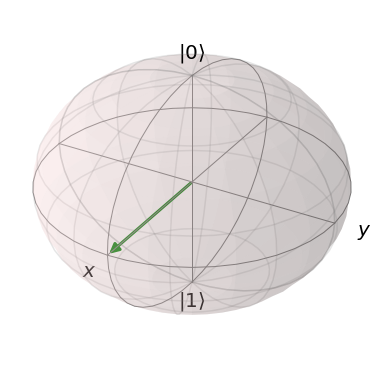

In [7]:
gate_param = {'phi': -pi/2, 'alpha': -3*pi/2}; #gate params

b= qt.Bloch(); #bloch sphere for plot
b.add_states(Uxy(gate_param)*qt.basis(2,0)); #add states due to application of gate Uxy on |0>
b.render()

<div class="alert alert-block alert-success">

## Including CU$_{xy}$ gate

</div>



In [160]:
CUxy(gate_param)
# expand_operator(CUxy(gate_param), None, targets=gate_param['targets'])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.00000000e+00j  0.70710678-4.32978028e-17j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [-0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   1.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  1.        +0.00000000e+00j]]

In [163]:
qc = QubitCircuit(3);
qc.user_gates = {"Uxy" : Uxy,
                 "CUxy" : CUxy,
                 "CPHASE": CPHASE,
                 "CZ" : CZ,
                 "XY": XY,
                 "pCUxy": pCUxy,
                 "pCZ": pCZ,
                 "globphase" : globphase}; #includes the new native gates in the QuTip gate lib for our circuit

# sequence for a CNOT gate using native Rydberg gates
gate_param = {'phi': pi/2, 'alpha': pi/2,
              'theta':pi/2, 'N':None, 'targets': [0,2],
              'phi00': pi/2, 'phi01': pi/2, 'phi10': pi/2, 'phi11': pi/2}; #params for gates

qc.add_gate("CUxy", arg_value=gate_param); #add gate to the quantum circuit

props = qc.propagators(); #calculate propagator
qc.png #show circuit image

RecursionError: maximum recursion depth exceeded in comparison

In [158]:
U = qt.gate_sequence_product(props); 
U.tidyup() #unitary operator of quantum circuit

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.70710678  0.          0.70710678  0.          0.          0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.70710678  0.          0.
   0.          0.        ]
 [-0.70710678  0.          0.70710678  0.          0.          0.
   0.          0.        ]
 [ 0.         -0.70710678  0.          0.70710678  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]

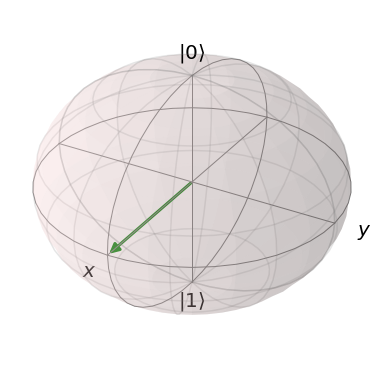

In [123]:
gate_param = {'phi': -pi/2, 'alpha': -3*pi/2}; #gate params

b= qt.Bloch(); #bloch sphere for plot
b.add_states(Uxy(gate_param)*qt.basis(2,0)); #add states due to application of gate Uxy on |0> of the controlled qubit
b.render()

<div class="alert alert-block alert-success">

## Including XY gate

</div>



In [101]:
XY(gate_param) #directly from function

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 6.123234e-17+0.j 0.000000e+00-1.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00-1.j 6.123234e-17+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j]]

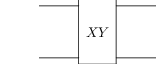

In [102]:
qc = QubitCircuit(2);
qc.user_gates = {"Uxy" : Uxy,
                 "CUxy" : CUxy,
                 "CPHASE": CPHASE,
                 "CZ" : CZ,
                 "XY": XY,
                 "pCUxy": pCUxy,
                 "pCZ": pCZ,
                 "globphase" : globphase}; #includes the new native gates in the QuTip gate lib for our circuit

# sequence for a CNOT gate using native Rydberg gates
gate_param = {'phi': pi/2, 'alpha': pi/2, 'theta':pi/2, 'N':None, 'targets': [0,1]}; #params for gates
qc.add_gate("XY", arg_value=gate_param); #add gate to the quantum circuit

props = qc.propagators(); #calculate propagator
qc.png #show circuit image

In [103]:
U = qt.gate_sequence_product(props); 
U.tidyup() #unitary operator of quantum circuit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

# Example of transpilation of CNOT gate using native Rydberg gates

In [53]:
qc = QubitCircuit(2)
qc.user_gates = {"Uxy" : Uxy,
                 "CUxy" : CUxy,
                 "CPHASE": CPHASE,
                 "CZ" : CZ,
                 "XY": XY,
                 "pCUxy": pCUxy,
                 "pCZ": pCZ,
                 "globphase" : globphase}

# sequence for a CNOT gate using native Rydberg gates
gate_param = {'phi': pi/2, 'alpha': pi/2, 'theta':pi/2}
qc.add_gate("Uxy", targets=[1], arg_value=gate_param)

qc.add_gate("CZ", controls=[0], targets=[1], arg_value=None)

gate_param = {'phi': -pi/2, 'alpha': pi/2, 'theta':pi/2}
qc.add_gate("Uxy", targets=[1], arg_value=gate_param)


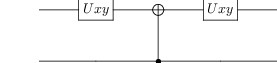

In [54]:
props = qc.propagators()
qc.png

In [55]:
U = qt.gate_sequence_product(qc.propagators())
U.tidyup()


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  1. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0.5-0.5j 0.5+0.5j]
 [0. +0.j  0. +0.j  0.5+0.5j 0.5-0.5j]]

# 

# Class ```algGate()```

In [ ]:
class algGate:
    """
        A class for building pulses shapes in time domain starting from AQiPT functions() for later
        build the AQiPT tracks() that can be assigned to AQiPT producers() via AQiPT instructions().

        The pulse class is the AQiPT representation of shaped pulse for create tracks.
        This class also show plots in matplotlib, as well as export the pulses as numpy arrays.


        Parameters
        ----------
        tbase : array_like
            Data for vector/matrix representation of the quantum object.
        res : list
            Dimensions of object used for tensor products.
        args : list
            Shape of underlying data structure (matrix shape).

        Attributes
        ----------
        function : array_like
            Sparse matrix characterizing the quantum object.
        function_plot : list
            List of dimensions keeping track of the tensor structure.

        Methods
        -------
        step()
            Conjugate of quantum object.
    """
    
    _gates_ = ['Uxy','Uxy','CPHASE', 'CZ', 'XY', 'pCUxy', 'pCZ', 'globphase']
    
    def __init__(self, times):
        
        #atributes
        self.nqubits = nr_qubits
        self.qcontrols = controls
        self.qtargets = targets
        self.argparams = params
        if name is in _gates
        self._name = name
        
    #single qubit gate
    
    def Uxy(self):
    return qt.Qobj(asarray([[cos(self.argparams['phi']/2), -1j*sin(self.argparams['phi']/2)*exp(1j*self.argparams['alpha'])],
                            [-1j*sin(self.argparams['phi']/2)*exp(-1j*self.argparams['alpha']), cos(self.argparams['phi']/2)]]))


    #two qubits gates

    def CUxy(self):
        if self.argparams['targets'] != [0, 1] and self.argparams['N'] is None:
            self.argparams['N'] = 2

        if self.argparams['N'] is not None:
            return qt.Qobj(expand_operator(CUxy(self.argparams), self.argparams['N'], targets=self.argparams['targets']), dims=[[2, 2], [2, 2]])

        return qt.Qobj(asarray([[cos(self.argparams['phi']/2), -1j*sin(self.argparams['phi']/2)*exp(1j*self.argparams['alpha']), 0, 0],
                                [-1j*sin(self.argparams['phi']/2)*exp(-1j*self.argparams['alpha']), cos(self.argparams['phi']/2), 0, 0],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]]), dims=[[2, 2], [2, 2]]);

    def CPHASE(arg_value):
        return qt.Qobj(asarray([[exp(1j*arg_value['phi00']), 0, 0, 0],
                                [0, exp(1j*arg_value['phi01']), 0, 0],
                                [0, 0, exp(1j*arg_value['phi10']), 0],
                                [0, 0, 0, exp(1j*arg_value['phi11'])]]), dims = [[2,2],[2,2]])

    def CZ():
        return CPHASE(0, 0, 0, pi)    

    def XY(arg_value):
        if arg_value['targets'] != [0, 1] and arg_value['N'] is None:
            arg_value['N'] = 2

        if arg_value['N'] is not None:
            return expand_operator(XY(arg_value), int(arg_value['N']), targets=arg_value['targets'])
        return qt.Qobj(asarray([[1, 0, 0, 0],
                                [0, cos(arg_value['phi']), -1j*sin(arg_value['phi']), 0], 
                                [0, -1j*sin(arg_value['phi']), cos(arg_value['phi']), 0],
                                [0, 0, 0, 1]]),
            dims=[[2, 2], [2, 2]])

    #multi-qubits gates

    def pCUxy(arg_value):
        return qt.Qobj(asarray([[cos(arg_value['theta']/2), -1j*sin(arg_value['theta']/2)*exp(1j*arg_value['varphi'])/sqrt(2), -1j*sin(arg_value['theta']/2)*exp(1j*arg_value['varphi'])/sqrt(2), 0],
                                [1j*sin(arg_value['theta']/2)*exp(-1j*arg_value['varphi'])/sqrt(2), cos(arg_value['theta']/4)**2, -sin(arg_value['theta']/4)**2, 0], 
                                [1j*sin(arg_value['theta']/2)*exp(-1j*arg_value['varphi'])/sqrt(2), -sin(arg_value['theta']/4)**2, cos(arg_value['theta']/4)**2, 0],
                                [0, 0, 0, 1]]), dims = [[2,2],[2,2]])

    def pCZ(arg_value):
        return CPHASE(0, arg_value['phi'], arg_value['phi'], 2*arg_value['phi']-pi)

    def globphase(arg_value):
        return qt.globalphase(arg_value['theta'])